# UPI Digital Payments Stress & Revenue Risk Model
Objective:
To quantify the financial and systemic impact of sustained UPI transaction contraction and estimate bank-level revenue exposure under multiple stress scenarios.

# Data Preparation

### Data Source
- Monthly UPI transaction volume and value
- Source: NPCI public statistics
- Period: Mid-2022 to Jan 2026 (latest complete month)

### Data Preparation
- Date parsing
- Unit normalization
- MoM growth computation
- 3-month moving averages
- Volatility estimation



### Load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\skhar\Desktop\Project\upi-stress-analysis\data\raw_upi.csv")

df["date"]=pd.to_datetime(df["date"], format="%d/%m/%Y")
df1 = df.sort_values("date").reset_index(drop=True)

df["volume_bn"] = df["volume (In Mn.)"]/1000
df["value_Trillion"] = df["value (In Cr.)"]/100000
df["avg_ticket_size"]=(df["value_Trillion"]*1000/df["volume_bn"])

df["MoM_vol%"]=df["volume_bn"].pct_change()*100
df["MoM_val%"] = df["value_Trillion"].pct_change()*100

df["MA_3M_vol"] = df["volume_bn"].rolling(3).mean()
df["MA_3M_val"] = df["value_Trillion"].rolling(3).mean()


mean_growth = df["MoM_vol%"].mean()
vol_volatility = df["MoM_vol%"].std()
val_volatility = df["MoM_val%"].std()

# BASELINE ECOSYSTEM ANALYSIS

### Compute CAGR - Volume & Value

In [5]:
# Start and End
start_date = df["date"].min()
end_date = df["date"].max()

start_vol = df.iloc[0]["volume_bn"]
end_vol = df.iloc[-1]["volume_bn"]

start_val = df.iloc[0]["value_Trillion"]
end_val = df.iloc[-1]["value_Trillion"]

# Calculating Years
num_years = (end_date - start_date).days/365

# CARG
carg_vol = ((end_vol/start_vol)**(1/num_years)-1)*100
carg_val = ((end_val/start_val)**(1/num_years)-1)*100

print("Volume CARG", round(carg_vol,2))
print("Value CARG", round(carg_val,2))

Volume CARG -30.56
Value CARG -24.89


In [ ]:
# YoY growth
df["year"] = df["date"].dt.year

yearly = df.groupby("year")[["volume_bn","value_Trillion"]].sum()

yearly["YoY_vol%"]= yearly["volume_bn"].pct_change()*100
yearly["YoY_val%"]= yearly["value_Trillion"].pct_change()*100

yearly

,volume_bn,value_Trillion,YoY_vol%,YoY_val%
year,,,,
2022,47.9560,79.512817,NaN,NaN
2023,117.6409,182.876349,145.310076,129.996063
2024,172.2081,246.825209,46.384548,34.968360
2025,228.2819,299.747375,32.561651,21.441151
2026,21.7035,28.334813,-90.492676,-90.547102


In [ ]:
# Peak volatility Months

df.sort_values("MoM_vol%").head(3)
df.sort_values("MoM_vol%",ascending=False).head(3)

,date,volume_bn,value_Trillion,MoM_vol%,MoM_val%,avg_ticket_size,MA_3M_vol,MA_3M_val,year
9,2023-03-01,8.6853,14.049506,15.269151,13.683252,1617.618965,8.085667,13.132853,2023
33,2025-03-01,18.3015,24.772216,13.630155,12.781345,1353.562058,17.134567,23.405801,2025
21,2024-03-01,13.4400,19.783532,11.049601,8.232744,1471.988988,12.581900,18.824355,2024


### Stability Metrics

In [ ]:
# Mean MoM Growth
df["MoM_vol%"].mean()

np.float64(3.2060229127504147)

In [ ]:
# Worst Historical Drop
df["MoM_vol%"].min()

np.float64(-6.650587880615023)

In [ ]:
# Frequency of Negative Months
negative_pct = (df["MoM_vol%"]<0).mean()*100
negative_pct

np.float64(29.545454545454547)

### Ticket size dynamics

In [ ]:
# Volume CARG vs Value CARG
print("Volume CARG", round(carg_vol,2))
print("Value CARG", round(carg_val,2))

Volume CARG 44.01
Value CARG 33.14


In [ ]:
# Ticket trend slope

x = np.arange(len(df))
y = df["avg_ticket_size"]

slope = np.polyfit(x,y,1)[0]
print("Ticket trend slope", slope)

Ticket trend slope -10.17535419156287


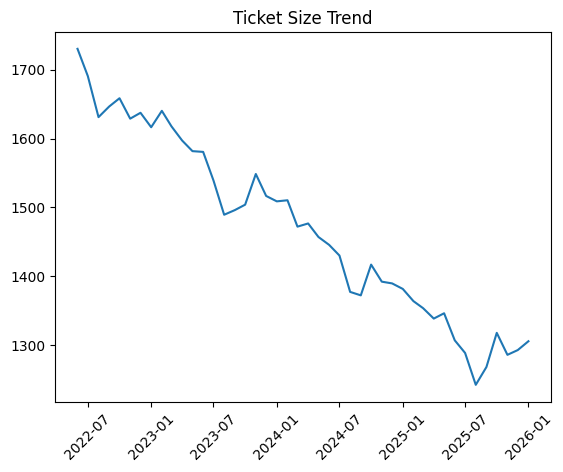

In [ ]:
# Visual Confirmation

plt.figure()
plt.plot(df["date"], df["avg_ticket_size"])
plt.title("Ticket Size Trend")
plt.xticks(rotation=45)
plt.show()

### Deviation from baseline volume

In [ ]:
# Real gap between baseline and stress
((1.009)**3)-((0.95)**3)

0.16986872899999972

In [ ]:
#baseline after 3 Months
vol_3M_Base = end_vol*(1.009)**3 # end_vol is the latest volume
vol_3M_Base

np.float64(22.29478427235149)

In [ ]:
#Stress after 3 Months
vol_3M_stress = end_vol*(0.95)**3
vol_3M_stress

np.float64(18.608038312499996)

In [ ]:
# deviation from baseline
Vol_deviation = vol_3M_Base - vol_3M_stress
Vol_deviation

np.float64(3.6867459598514927)

In [ ]:
# Latest ticket
latest_ticket = df.iloc[-1]["avg_ticket_size"]
latest_ticket

np.float64(1305.5411799940102)

In [ ]:
# Real deviation value
value_gap = Vol_deviation*latest_ticket
value_gap

np.float64(4813.1986707626675)

# Stress Scenario Modeling

### Define Baseline

In [ ]:
baseline_growth = df["MoM_vol%"].mean()/100
baseline_growth # converting to decimal

np.float64(0.03206022912750415)

In [ ]:
baseline_3M = end_vol*(1+baseline_growth)**3
baseline_3M

baseline_2M = end_vol*(1+baseline_growth)**2
baseline_2M

np.float64(23.11744648817165)

### Scenario 1 - Mild Stress

In [ ]:
# -3% for 2 Months
mild_vol = end_vol * (0.97)**2
mild_gap = baseline_2M - mild_vol
mild_value_gap = mild_gap * latest_ticket
mild_value_gap

np.float64(3520.552814916009)

### Scenario 2 - Moderate Stress

In [ ]:
moderate_vol = end_vol * (0.95) **3
moderate_gap = baseline_3M - moderate_vol
moderate_value_gap = moderate_gap * latest_ticket
moderate_value_gap

np.float64(6854.820740421141)

### Scenario 3 - Severe Stress

In [ ]:
# Baseline growth for 6 Months
baseline_6M = end_vol * (1+ baseline_growth) **6
baseline_6M

# Stress
severe_vol = end_vol * (0.93) **6
severe_gap = baseline_6M - severe_vol
severe_value_gap = severe_gap * latest_ticket
severe_value_gap

np.float64(15908.982683718868)

### Scenario table

In [ ]:
scenario_df = pd.DataFrame({"Scenario": ["Mild(-3% x2)","Moderate(-5% x3)","Severe(-7% x6)"],
                            "Baseline Projection (Bn)": [baseline_2M,baseline_3M,baseline_6M],
                            "Volume After Stress (Bn)": [mild_vol,moderate_vol,severe_vol],
                            "Deviation vs Baseline (Bn)": [mild_gap,moderate_gap,severe_gap],
                            "Value Impact (Trillion)": [mild_value_gap/1000, moderate_value_gap/1000,
                                                        severe_value_gap/1000]})

scenario_df

,Scenario,Baseline Projection (Bn),Volume After Stress (Bn),Deviation vs Baseline (Bn),Value Impact (Trillion)
0,Mild(-3% x2),23.117446,20.420823,2.696623,3.520553
1,Moderate(-5% x3),23.858597,18.608038,5.250559,6.854821
2,Severe(-7% x6),26.227689,14.041951,12.185738,15.908983


Mild stress produces manageable deviation

Moderate stress creates multi trillion shortfall

Severe stress causes systemic contraction and major deviation from growth trajectory

### Relative Deviation

In [ ]:
relative_gap = Vol_deviation / vol_3M_Base

In [ ]:
scenario_df["Relative_Gap_%"] = round((scenario_df["Deviation vs Baseline (Bn)"]/scenario_df["Baseline Projection (Bn)"])*100,2)
scenario_df

,Scenario,Baseline Projection (Bn),Volume After Stress (Bn),Deviation vs Baseline (Bn),Value Impact (Trillion),Relative_Gap_%
0,Mild(-3% x2),23.117446,20.420823,2.696623,3.520553,11.66
1,Moderate(-5% x3),23.858597,18.608038,5.250559,6.854821,22.01
2,Severe(-7% x6),26.227689,14.041951,12.185738,15.908983,46.46


### Z Score Interpretation

In [ ]:
 # Defining variables
mean_mom = df["MoM_vol%"].mean()
volatility = df["MoM_vol%"].std()

print("Mean MoM:", mean_mom)
print("Volatility:",volatility)

Mean MoM: 3.2060229127504147
Volatility: 4.947304103022153


In [ ]:
# Z score = (shock - mean)/ volatility
z_mild = (-3-mean_mom)/volatility
z_moderate = (-5-mean_mom)/volatility
z_severe = (-7-mean_mom)/volatility

print("Mild Z:", round(z_mild,2))
print("Moderate Z:", round(z_moderate,2))
print("Severe Z:", round(z_severe,2))

Mild Z: -1.25
Moderate Z: -1.66
Severe Z: -2.06


In [ ]:
scenario_df["Z Score"] = [round(z_mild,2), round(z_moderate,2), round(z_severe,2)]
scenario_df

,Scenario,Baseline Projection (Bn),Volume After Stress (Bn),Deviation vs Baseline (Bn),Value Impact (Trillion),Relative_Gap_%,Z Score
0,Mild(-3% x2),23.117446,20.420823,2.696623,3.520553,11.66,-1.25
1,Moderate(-5% x3),23.858597,18.608038,5.250559,6.854821,22.01,-1.66
2,Severe(-7% x6),26.227689,14.041951,12.185738,15.908983,46.46,-2.06


##### Statistical Context of Stress Assumptions

Historical mean MoM growth: 3.2%

Historical volatility: 4.95%

Mild shock (-3%) → -1.25σ

Moderate shock (-5%) → -1.66σ

Severe shock (-7%) → -2.07σ

While single-month shocks within 1–2σ occur periodically, sustained contraction compounds into structural deviation from expected growth trajectory.

# Revenue Sensitivity


### Assumptions

Hypothetical bank market share: 12%

Effective monetization yield bands:

0.05%

0.10%

0.20%

Revenue estimated as a fraction of transaction value throughput

Value gap derived from stress scenario modeling

In [ ]:
# Converting value gap to rupees

mild_gap_rs = mild_value_gap
moderate_gap_rs = moderate_value_gap
severe_gap_rs = severe_value_gap

In [ ]:
# Define fee rates

fee_rates = [0.0005,0.001,0.002] # 0.05%, 0.1%, 0.2%
market_share = 0.12

In [ ]:
# Calculate Ecosystem Revenue Sensitivity

for rate in fee_rates:
    revenue_loss = moderate_gap_rs * rate
    revenue_loss_crore = revenue_loss * 100
    print(revenue_loss_crore)


342.741037021057
685.482074042114
1370.964148084228


In [ ]:
# Bank Level Exposure

for rate in fee_rates:
    bank_revenue_loss = moderate_gap_rs * rate * market_share
    bank_revenue_loss_crore = bank_revenue_loss *100
    print(round(bank_revenue_loss_crore,2))

41.13
82.26
164.52


In [ ]:
# Bank Revenue Risk

selected_rate = 0.001 # chosen case

mild_bank_Revenue_loss_cr = mild_gap_rs * selected_rate * market_share * 100
mild_bank_risk = mild_bank_Revenue_loss_cr

moderate_bank_Revenue_loss_cr = moderate_gap_rs * selected_rate * market_share * 100
moderate_bank_risk = moderate_bank_Revenue_loss_cr

severe_bank_Revenue_loss_cr = severe_gap_rs * selected_rate * market_share * 100
severe_bank_risk = severe_bank_Revenue_loss_cr

In [ ]:

scenario_df["Bank Revenue Risk Cr"] = [mild_bank_risk,moderate_bank_risk,severe_bank_risk]
scenario_df


,Scenario,Baseline Projection (Bn),Volume After Stress (Bn),Deviation vs Baseline (Bn),Value Impact (Trillion),Relative_Gap_%,Z Score,Bank Revenue Risk Cr
0,Mild(-3% x2),23.117446,20.420823,2.696623,3.520553,11.66,-1.25,42.246634
1,Moderate(-5% x3),23.858597,18.608038,5.250559,6.854821,22.01,-1.66,82.257849
2,Severe(-7% x6),26.227689,14.041951,12.185738,15.908983,46.46,-2.06,190.907792


### Final Table

In [ ]:
final_df1 = pd.DataFrame({"Scenario": ["Mild(-3% x2)","Moderate(-5% x3)","Severe(-7% x6)"],
                            "Baseline Projection (Bn)": [baseline_2M,baseline_3M,baseline_6M],
                            "Stressed Volume (Bn)": [mild_vol,moderate_vol,severe_vol],
                            "Volume Deviation (Bn)": [mild_gap,moderate_gap,severe_gap],
                            "Value Impact (Trillion)": [mild_value_gap/1000, moderate_value_gap/1000, severe_value_gap/1000],
                            "Relative Gap %": scenario_df["Relative_Gap_%"].tolist(),
                            "Z Score": [round(z_mild,2), round(z_moderate,2), round(z_severe,2)],
                            "Bank Revenue Risk Cr": [mild_bank_risk,moderate_bank_risk,severe_bank_risk]})

final_df1

,Scenario,Baseline Projection (Bn),Stressed Volume (Bn),Volume Deviation (Bn),Value Impact (Trillion),Relative Gap %,Z Score,Bank Revenue Risk Cr
0,Mild(-3% x2),23.117446,20.420823,2.696623,3.520553,11.66,-1.25,42.246634
1,Moderate(-5% x3),23.858597,18.608038,5.250559,6.854821,22.01,-1.66,82.257849
2,Severe(-7% x6),26.227689,14.041951,12.185738,15.908983,46.46,-2.06,190.907792


Z score measures how extreme the stress deviation is relative to historical volatility

UPI ecosystem exhibits ~3.2% mean MoM growth.

Historical volatility ~4.95%.

Moderate stress implies ~1.66σ contraction.

At 12% exposure and 0.1% fee realization, bank faces ~₹82 Cr revenue risk.

# Early Warning Framework

In [ ]:
# Define Thresholds
mean_growth = 3.206
warning_threshold = mean_growth - volatility #-1σ
critical_threshold = mean_growth - 2*volatility #-2σ
volatility,warning_threshold,critical_threshold

(np.float64(4.947304103022153),
 np.float64(-1.7413041030221534),
 np.float64(-6.688608206044307))

In [ ]:
# Classify each month

def classify_stress(x):
    if x <= critical_threshold:
        return "Critical"
    elif x <= warning_threshold:
        return "Watchlist"
    else:
        return "Normal"
    
df["Stress Level"] = df["MoM_vol%"].apply(classify_stress)
df["Stress Level"].value_counts()

Stress Level
Normal       39
Watchlist     5
Name: count, dtype: int64

In [ ]:
# Add consecutive negative detection

df["Negative"] = df["MoM_vol%"] <0
df["consecutive_negative"] = (df["Negative"].groupby((df["Negative"] != df["Negative"].shift()).cumsum()).cumcount()+1)*df["Negative"]
df[df["consecutive_negative"]>=3]

,date,volume_bn,value_Trillion,MoM_vol%,MoM_val%,avg_ticket_size,MA_3M_vol,MA_3M_val,year,Stress Level,Negative,consecutive_negative


In [ ]:
early_warning_summary = pd.DataFrame({"Metric":[
    "Mean MoM Growth",
    "Volatitlity",
    "Warning Threshold (-1σ)",
    "Critical Threshold (-2σ)",
    "Total Watchlist Months",
    "Total Critical Months"
],
"Value": [
    mean_growth,
    volatility,
    warning_threshold,
    critical_threshold,
    (df["Stress Level"] == "Watchlist").sum(),
    (df["Stress Level"] == "Critical").sum()
    ]
})

early_warning_summary

,Metric,Value
0,Mean MoM Growth,3.206000
1,Volatitlity,4.947304
2,Warning Threshold (-1σ),-1.741304
3,Critical Threshold (-2σ),-6.688608
4,Total Watchlist Months,5.000000
5,Total Critical Months,0.000000


### Integrate Early Warning with Revenue Risk Trigger

In [ ]:
# Stress severity mapping
def map_scenario(stress_level):
    if stress_level == "Watchlist":
        return "Mild"
    elif stress_level == "Critical":
        return "Moderate"
    else:
        return "Normal"

df["Mapped_Scenario"] = df["Stress Level"].apply(map_scenario)

In [ ]:
# Attach Revenue Impact to Scenario
scenario_revenue_map = {
    "Normal": 0,
    "Mild": 42.24,
    "Moderate": 82.25,
    "Severe": 190.90
}

df["Estimated_Revenue_Risk_Cr"] = df["Mapped_Scenario"].map(scenario_revenue_map)

In [ ]:
# Risk Monitor Table
risk_monitor = df[[
    "date",
    "MoM_vol%",
    "Stress Level",
    "Mapped_Scenario",
    "Estimated_Revenue_Risk_Cr"
]].tail(12)

risk_monitor

,date,MoM_vol%,Stress Level,Mapped_Scenario,Estimated_Revenue_Risk_Cr
32,2025-02-01,-5.235349,Watchlist,Mild,42.24
33,2025-03-01,13.630155,Normal,Normal,0.00
34,2025-04-01,-2.229872,Watchlist,Mild,42.24
35,2025-05-01,4.382063,Normal,Normal,0.00
36,2025-06-01,-1.512515,Normal,Normal,0.00
37,2025-07-01,5.833107,Normal,Normal,0.00
38,2025-08-01,2.775324,Normal,Normal,0.00
39,2025-09-01,-1.873722,Watchlist,Mild,42.24
40,2025-10-01,5.437163,Normal,Normal,0.00
41,2025-11-01,-1.129903,Normal,Normal,0.00


In [ ]:
# Trigger Condition
df["Revenue_Risk_Alert"] = df["Estimated_Revenue_Risk_Cr"] > 0

df["Revenue_Risk_Alert"].sum()

np.int64(5)